In [14]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from torch.utils.data import Dataset
import scipy.io
import torch
!pwd

sys.path.append('../')
from module.Pingfan_ver2_datamodule import MRIDataModule
from script.trainer import our_GRU, model_load_matcher

import pwd

from jinja2 import ModuleLoader
import pytorch_lightning as pl
import torch
import torchvision
from torch.utils.data import random_split, DataLoader, Dataset
import numpy as np
import os
import scipy.io
import sys
import mat73
import h5py
from script.trainer import BlochSeqEqDecoder, BlochImgEqDecoder
from Bloch_decoder.utils.generate_RF_TR import generate_RF_TR

/mnt/ssd/jj/Research/cauMedical/lightning_bolts/script


# Data module

In [15]:


class MRIDataModule(pl.LightningDataModule):
    def __init__(
        self,
        batch_size: int = 1,
        num_workers=0,
        train_data_type="seq",
        test_data_type="real",
        subsamp=1,
        seq_jump=5,
        is_input_RF=0,
        need_T1T2_logscale=False,
        need_TETR_second=False,
        need_RF_degree=False,
    ):  # img_cnn, img_seq, seq
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_data_type = train_data_type
        self.testdata_type = test_data_type
        self.subsamp = subsamp
        self.seq_jump = seq_jump
        self.need_T1T2_logscale = need_T1T2_logscale
        self.need_TETR_second = need_TETR_second
        self.need_RF_degree = need_RF_degree
        self.datamodule = PingSeqDataset

        self.n_img_tr = 80 * 128 * 128
        self.n_img_te = 22 * 128 * 128

    def prepare_data(self):
        return

    def setup(self, stage=None):
        # Trainset
        if "seqTr" in self.train_data_type:
            self.trainset = self.datamodule(
                mode="train",
                is_split_range_T1T2=True,
                need_T1T2_logscale=self.need_T1T2_logscale,
                need_TETR_second=self.need_TETR_second,
                need_RF_degree=self.need_RF_degree,
            )
        elif "seqAll" in self.train_data_type:
            self.trainset = self.datamodule(
                mode="none",
                is_split_range_T1T2=False,
                need_T1T2_logscale=self.need_T1T2_logscale,
                need_TETR_second=self.need_TETR_second,
                need_RF_degree=self.need_RF_degree,
            )
        elif "phantomTr" in self.train_data_type:
            self.trainset = PingImgDataset_Phantom(mode="train")
        elif "phantomAll" in self.train_data_type:
            self.trainset = PingImgDataset_Phantom(mode="none")
        else:
            raise AssertionError("Check traindata_type")

        # Testset
        if "seqTe" in self.testdata_type:
            self.testset = self.datamodule(
                mode="test",
                is_split_range_T1T2=True,
                need_T1T2_logscale=self.need_T1T2_logscale,
                need_TETR_second=self.need_TETR_second,
                need_RF_degree=self.need_RF_degree,
            )
        elif "phantomTe" in self.testdata_type:
            self.testset = PingImgDataset_Phantom(mode="test")
        elif "phantomAll" in self.testdata_type:
            self.testset = PingImgDataset_Phantom(mode="none")
        elif "real" in self.testdata_type:
            self.testset = PingImgDataset_real(
                need_T1T2_logscale=self.need_T1T2_logscale,
                need_TETR_second=self.need_TETR_second,
                need_RF_degree=self.need_RF_degree,
            )
        else:
            raise AssertionError("Check testdata_type")

    def setup_before(self, stage=None):

        if "dictionary" in self.data_type:
            # seq train / seq test
            # seq_all train / real or phantom_all test
            # phantom train / phantom test
            # phantom all / real test

            # Trainset
            if "train_seqTR" in self.data_type:
                self.trainset = self.datamodule(
                    mode="train",
                    is_split_range_T1T2=True,
                    need_T1T2_logscale=self.need_T1T2_logscale,
                    need_TETR_second=self.need_TETR_second,
                    need_RF_degree=self.need_RF_degree,
                )
            elif "train_seqAll" in self.data_type:
                self.trainset = self.datamodule(
                    mode="none",
                    is_split_range_T1T2=False,
                    need_T1T2_logscale=self.need_T1T2_logscale,
                    need_TETR_second=self.need_TETR_second,
                    need_RF_degree=self.need_RF_degree,
                )
            elif "train_phantomTr" in self.data_type:
                self.trainset = PingImgDataset_Phantom(mode="train")
            elif "train_phantomAll" in self.data_type:
                self.trainset = PingImgDataset_Phantom(mode="none")

            # Test set
            if "test_seqTE" in self.data_type:
                self.testset = self.datamodule(
                    mode="test",
                    is_split_range_T1T2=True,
                    need_T1T2_logscale=self.need_T1T2_logscale,
                    need_TETR_second=self.need_TETR_second,
                    need_RF_degree=self.need_RF_degree,
                )
            elif "test_phantomTe" in self.data_type:
                self.testset = PingImgDataset_Phantom(mode="test")
            elif "test_phantomAll" in self.data_type:
                self.testset = PingImgDataset_Phantom(mode="none")
            elif "test_real" in self.data_type:
                self.testset = PingImgDataset_real(
                    need_T1T2_logscale=self.need_T1T2_logscale,
                    need_TETR_second=self.need_TETR_second,
                    need_RF_degree=self.need_RF_degree,
                )

        elif "img_img" in self.data_type:
            self.trainset = PingImgDataset_Phantom(mode="train")
            self.testset = PingImgDataset_Phantom(mode="test")

        elif "seq_img" in self.data_type:
            self.trainset = self.datamodule(
                mode="train",
                is_split_range_T1T2=True,
                need_T1T2_logscale=self.need_T1T2_logscale,
                need_TETR_second=self.need_TETR_second,
                need_RF_degree=self.need_RF_degree,
            )
            self.testset = PingImgDataset_Phantom(mode="test")
        elif "seq_seq" in self.data_type:
            self.trainset = self.datamodule(
                mode="train",
                is_split_range_T1T2=True,
                need_T1T2_logscale=self.need_T1T2_logscale,
                need_TETR_second=self.need_TETR_second,
                need_RF_degree=self.need_RF_degree,
            )
            self.testset = self.datamodule(
                mode="test",
                is_split_range_T1T2=True,
                need_T1T2_logscale=self.need_T1T2_logscale,
                need_TETR_second=self.need_TETR_second,
                need_RF_degree=self.need_RF_degree,
            )
        elif "img_none" in self.data_type:  # This is for training RNN
            self.trainset = PingImgDataset_Phantom(mode="none")
            self.testset = PingImgDataset_Phantom(mode="none")

        elif "seq_none" in self.data_type:  # This is for training RNN
            self.trainset = self.datamodule(
                mode="none",
                is_split_range_T1T2=False,
                need_T1T2_logscale=self.need_T1T2_logscale,
                need_TETR_second=self.need_TETR_second,
                need_RF_degree=self.need_RF_degree,
            )
            self.testset = self.datamodule(
                mode="none",
                is_split_range_T1T2=False,
                need_T1T2_logscale=self.need_T1T2_logscale,
                need_TETR_second=self.need_TETR_second,
                need_RF_degree=self.need_RF_degree,
            )
        elif "real_img" in self.data_type:
            self.trainset = PingImgDataset_real(
                need_T1T2_logscale=self.need_T1T2_logscale,
                need_TETR_second=self.need_TETR_second,
                need_RF_degree=self.need_RF_degree,
            )
            self.testset = PingImgDataset_real(
                need_T1T2_logscale=self.need_T1T2_logscale,
                need_TETR_second=self.need_TETR_second,
                need_RF_degree=self.need_RF_degree,
            )
        else:
            raise AssertionError("data_type should be in [img_img, seq_seq, seq_img, img_none, seq_none]")

    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.testset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.testset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def predict_dataloader(self):
        return DataLoader(self.testset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)


class PingSeqDataset(Dataset):
    # Input : T1T2, RF, TE, TR
    def __init__(
        self,
        mode="train",
        is_split_range_T1T2=True,
        need_T1T2_logscale=False,
        need_TETR_second=False,
        need_RF_degree=False,
    ):
        """
        Approx RNN input : (need_T1T2_logscale=True, need_TETR_second=True, need_RF_degree=True)
        Our Bloch decoder input : (need_T1T2_logscale=False, need_TETR_second=False, need_RF_degree=False)
        This data : (need_T1T2_logscale=False, need_TETR_second=False, need_RF_degree=False)
        """

        L = 1000
        subsamp = 1
        len_seq = L // subsamp
        T1_condition_threshold = 2500
        T2_condition_threshold = 1000
        MRFData = scipy.io.loadmat(
            "/mnt/ssd/jj/Research/cauMedical/lightning_bolts/Bloch_decoder/data/Pingfan/D_LUT_L1000_TE10_Start1_Train.mat"
        )
        MRFData_Val = scipy.io.loadmat(
            "/mnt/ssd/jj/Research/cauMedical/lightning_bolts/Bloch_decoder/data/Pingfan/D_LUT_L1000_TE10_Start5_Val.mat"
        )  #
        self.is_split_range_T1T2 = is_split_range_T1T2 if "none" not in mode else False

        self.labels = np.concatenate((MRFData["LUT"], MRFData_Val["LUT"]), 0)
        self.labels = torch.from_numpy(self.labels)

        self.D = np.concatenate((np.real(MRFData["D"]), np.real(MRFData_Val["D"])), 0)
        self.D = torch.from_numpy(self.D[:, 0:L:subsamp])
        self.D = torch.nn.functional.normalize(self.D, p=2.0, dim=1)

        if self.is_split_range_T1T2:
            # Split train and test set : T1 0~2500, 2500~5000
            T1 = self.labels[:, 0]
            T2 = self.labels[:, 1]
            condition = (
                (T1 < T1_condition_threshold) & (T2 < T2_condition_threshold)
                if "train" in mode
                else (T1 > T1_condition_threshold) & (T2 > T2_condition_threshold)
            )
            self.labels = self.labels[condition]
            self.D = self.D[condition]

        # T1T2 scale
        self.T1 = self.labels[:, 0].unsqueeze(1).repeat(1, len_seq).unsqueeze(1)
        self.T2 = self.labels[:, 1].unsqueeze(1).repeat(1, len_seq).unsqueeze(1)
        if need_T1T2_logscale == True:
            self.T1 = torch.log10(self.T1)
            self.T2 = torch.log10(self.T2)

        # RF, TR, TE
        RFpulses, TR = generate_RF_TR(L)  #%Load slowly changing RF and TR values
        RFpulses = RFpulses[0:L:subsamp]  #% undersampling in time dimension.

        self.RFpulses = RFpulses.repeat(len(self.labels), 1).unsqueeze(1)
        self.TR = TR[0:L:subsamp].repeat(len(self.labels), 1).unsqueeze(1)
        self.TE = torch.ones(len(self.labels), 1, len_seq) * 10

        if need_RF_degree == True:
            self.RFpulses = self.RFpulses * 180 / torch.pi

        if need_TETR_second == True:
            self.TR = self.TR / 1000
            self.TE = self.TE / 1000

        # Concat
        self.labels = torch.cat((self.RFpulses, self.T1, self.T2, self.TE, self.TR), 1).transpose(
            1, 2
        )  # (80100, 5, 200)

        # This if for Debug
        # self.labels = self.labels[0:20]
        # self.D = self.D[0:20]

    def __len__(self):
        return len(self.D)

    def __getitem__(self, idx):
        return self.D[idx], self.labels[idx]


class PingImgDataset_Phantom(Dataset):
    """
    This get item by slice
    """

    # Input : T1T2, RF, TE, TR
    def __init__(self, mode="train"):
        """
        This data already done transformation
        So now : (need_T1T2_logscale=True, need_TETR_second=True, need_RF_degree=True)
        """

        # load file
        path = "/mnt/ssd/jj/Research/cauMedical/lightning_bolts/Bloch_decoder/data/Pingfan/remove_image_all/"
        if "test" in mode:
            # !!!!!!!!!!!!!!!!!!!!!!!!!
            sl_file = "test_10subject_4_5_slices_MRIs"
            # !!!!!!!!!!!!!!!!!!!!!!!!!
        elif "train" in mode:
            sl_file = "train_10subject_4_5_slices_MRIs"
        elif "none" in mode:
            # !!!!!!!!!!!!!!!!!!!!!!!!!
            sl_file = "all_10subject_4_5_slices_MRIs"  # "all_MRIs" !!!!!!!!!!!!!!!!!!!!!!!!!
            # !!!!!!!!!!!!!!!!!!!!!!!!!
        sl_file_name = path + sl_file
        data_h5py = h5py.File(sl_file_name + ".h5", "r")
        self.D = data_h5py["X_all"]
        self.labels = data_h5py["labels"]

        # st = 130072
        # self.D = self.D[st : st + 1000]  # [0 : len(self.D) : 100]
        # self.labels = self.labels[st : st + 1000]  # [0 : len(self.labels) : 100]

        print("Data shape: ", self.D.shape, self.labels.shape)

    def __len__(self):
        return len(self.D)

    def __getitem__(self, idx):
        return self.D[idx], self.labels[idx]


In [32]:
data_module = MRIDataModule(
            batch_size=128*128*2*2, num_workers=4, train_data_type="seqTr", test_data_type='phantomTe', subsamp=1, seq_jump=5, is_input_RF=1,
            need_T1T2_logscale=True, need_TETR_second=True, need_RF_degree=True,
        )
data_module.prepare_data()
data_module.setup()

train_loader = data_module.train_dataloader()
test_loader = data_module.test_dataloader()


Data shape:  (42845, 1000) (42845, 5, 1000)


In [20]:
batch = next(iter(train_loader))
batch_test = next(iter(test_loader))
x, y = batch
print(x.shape, y.shape)

# plt.plot(x)

torch.Size([40, 1000]) torch.Size([40, 1000, 5])


# Baseline: Dictionary

In [149]:
# Get D and save
# Get input and matrix multiple
# Select index
# Select T1T2 from LUT

In [33]:
def FLOR_dictionary_based(x, data_module):
    # Get and save D, LUT
    dictionary = data_module.trainset.D.t()
    LUT_T1T2 = data_module.trainset.labels[:,1:3,0]

    # Get input and matrix multiple
    # Ex (1, 1000) * (100, 1000)^T = 1*100
    # Ex (40, 1000) * (100, 1000)^T = 40*100
    simm = torch.matmul(x,dictionary)

    # Select index
    max_idx = torch.argmax(simm, dim=1)

    # Select T1T2 from LUT
    T1T2_hat = LUT_T1T2[max_idx]
    
    return T1T2_hat

In [34]:
T1T2_hat_ = FLOR_dictionary_based(x, data_module)
loss = torch.nn.functional.mse_loss(T1T2_hat_, y[:,1:3, 0])
print(loss)
for i in range(5):
    print(y[i,1:3,0], T1T2_hat_[i])

tensor(0.)
tensor([6.4100, 6.8800]) tensor([6.4100, 6.8800])
tensor([6.4100, 6.8800]) tensor([6.4100, 6.8800])
tensor([6.4100, 6.8800]) tensor([6.4100, 6.8800])
tensor([6.4100, 6.8800]) tensor([6.4100, 6.8800])
tensor([6.4100, 6.8800]) tensor([6.4100, 6.8800])


In [35]:
for i, batch in enumerate(test_loader):
    x, y = batch
    T1T2_hat_ = FLOR_dictionary_based(x, data_module)
    loss = torch.nn.functional.mse_loss(T1T2_hat_, y[:,1:3, 0])
    print(loss)

tensor(12.8609, dtype=torch.float64)


# Phantomdata save as npz(for dictionary)

In [159]:
file="/mnt/ssd/jj/Research/cauMedical/lightning_bolts/Bloch_decoder/data/Pingfan/remove_image_all/train_10subject_4_5_slices_MRIs.npz"

x = np.load(file)
x["X_all"].shape



(21215, 1000)

# Check img slices

In [42]:
import scipy.io
import sys
import h5py
import numpy as np
import mat73
import torch
import matplotlib.pyplot as plt

D = []  # D : (sub, slice, 128*128, 1000)
labels = []  # labels : (sub, slice, 128*128, (T1, T2)) = ()


subject_list = ["04"]
n_slice_per_subject = 10
L = 1000
subsamp = 1
len_seq = L // subsamp
need_T1T2_logscale = True
is_split_range_T1T2 = False
T1_condition_threshold = 1000
T2_condition_threshold = 50
need_RF_degree = True
need_TETR_second = True
mode = "train"
slice_num_now = 0

save={}


for i in range(len(subject_list)):
    file = "subject" + str(subject_list[i]) + "_MRIs.mat"
    file_name = "/mnt/ssd/jj/Research/cauMedical/lightning_bolts/Bloch_decoder/data/Pingfan/image_by_subject/" + file
    data_dict = mat73.loadmat(file_name)

    for s in range(0,10): #range(n_slice_per_subject):

        if s > len(data_dict["X_all"]) - 1:  # some subjects only have 10 slices instead of 12 slices
            continue

        # X_all(fully sampled image sequence)
        D_slice = torch.from_numpy(data_dict["X_all"][s][:, 0:L:subsamp])  # (128, 128, 1000)
        
        save[s] = D_slice




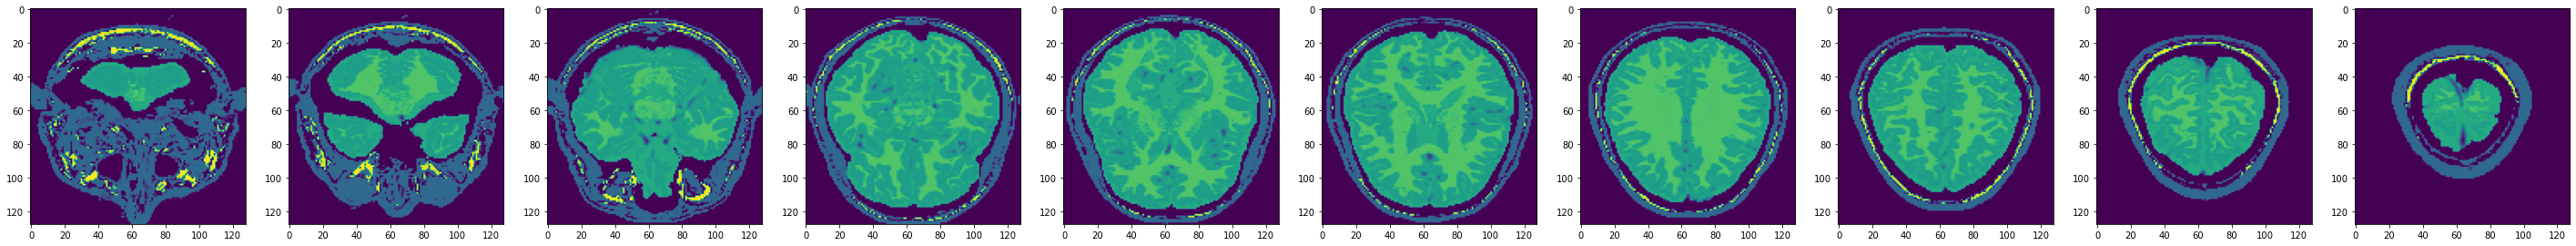

In [45]:
plt.figure(figsize = (50,50) )
for i in range(0, 10):
    plt.subplot(1, 10, i+1)
    plt.imshow((save[i][:,:,600]).real)

# Baseline method: Hydra

In [111]:
from torch import nn
from torch.nn.functional import relu


class Hydra_Encoder(nn.Module):
        
    def conv1d(self, in_planes, out_planes, kernel_size=3):
        return nn.Conv1d(in_planes, out_planes, kernel_size=kernel_size, stride=1, padding="same", bias=True)
    
    def forward(self, x):
        return self.resnet_MRF(x)
    
    def resnet_layer(self,
        inputs,
         
        out_channels=16,
        kernel_size=3,
        strides=1,
        activation="relu",
        batch_normalization=True,
        conv_first=True,
    ):
        """1D Convolution-Batch Normalization-Activation stack builder
        # Arguments
            inputs (tensor): input tensor from input 1D signal
            num_filters (int): Conv1D number of filters
            kernel_size (int): Conv1D kernel dimensions
            strides (int): Conv1D stride dimensions
            activation (string): activation name
            batch_normalization (bool): whether to include batch normalization
            conv_first (bool): conv-bn-activation (True) or
                bn-activation-conv (False)
        # Returns
            x (tensor): tensor as input to the next layer
        """
        in_channels = inputs.shape[1]
        r_c1 = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=strides,
            padding="same",
        )
        x = inputs
        if conv_first:
            x = r_c1(x)
            if batch_normalization:
                x = nn.BatchNorm1d(out_channels)(x)
            if activation is not None:
                x = relu(x)
        else:  # full pre-activation
            if batch_normalization:
                x = nn.BatchNorm1d(in_channels)(x)
            if activation is not None:
                x = relu(x)
            x = r_c1(x)
        return x
    
    def resnet_MRF(
        self,
        x
    ):
        # create model CNN
        """ResNet Version 1 Model builder
        Stacks of BN-ReLU-Conv1D
        # Arguments
            input_shape (tensor): shape of input image tensor, e.g. 200x1
            depth (int): number of core convolutional layers, 6n+2, e.g. 20, 32, 44
            num_classes (int): number of classes, e.g.2 types of tissue parameters,
            T1 and T2)
        # Returns
            model (Model): Keras model instance
        """

        # Shape of input

        c1 = self.conv1d(1, 16, kernel_size=21)
        c2 = self.conv1d(16, 16, kernel_size=21)
        mp1 = nn.MaxPool1d(2)
        non_local_block_32 = NLBlockND(in_channels=32, mode='embedded', dimension=1, bn_layer=False)
        non_local_block_64 = NLBlockND(in_channels=64, mode='embedded', dimension=1, bn_layer=False)
        non_local_block_128 = NLBlockND(in_channels=128, mode='embedded', dimension=1, bn_layer=False)
        linear = nn.Linear(50,2)

        # Forward
        
        # shape change
        x = x.unsqueeze(1)
        print(x.shape)

        # conv1d relu
        # conv1d relu
        # non local block
        # maxplooling

        x = c1(x)
        x = c2(x)
        x = mp1(x)

        # x = resnet_layer
        # y = resnet_layer
        # x+y
        # non local block
        # maxplling

        print(x.shape,'---')
        x = self.resnet_layer(x, out_channels=32, kernel_size=1)
        print(x.shape,'---')
        y = self.resnet_layer(x, out_channels=32, kernel_size=21)
        x = x+y
        print(x.shape)
        x = non_local_block_32(x)  # mode: `embedded`, `gaussian`, `dot` or `concatenate`.
        print(x.shape)
        

        print(x.shape,'---')
        x = self.resnet_layer(x, out_channels=64, kernel_size=1)
        print(x.shape,'---')
        y = self.resnet_layer(x, out_channels=64, kernel_size=21)
        x = x+y
        print(x.shape)
        x = non_local_block_64(x)  # mode: `embedded`, `gaussian`, `dot` or `concatenate`.

        print(x.shape,'---')
        x = self.resnet_layer(x, out_channels=128, kernel_size=1)
        print(x.shape,'---')
        y = self.resnet_layer(x, out_channels=128, kernel_size=21)
        x = x+y
        x = non_local_block_128(x)  # mode: `embedded`, `gaussian`, `dot` or `concatenate`.

        # Gloval average pooling
        # Fully connected
        x = torch.mean(x, 1)
        x = linear(x)
        print(x.shape)
        

In [112]:
inp = torch.randn((5, 100))
cl = Hydra_Encoder()

cl.resnet_MRF(inp)

torch.Size([5, 1, 100])
torch.Size([5, 16, 50]) ---
torch.Size([5, 32, 50]) ---
torch.Size([5, 32, 50])
torch.Size([5, 32, 50])
torch.Size([5, 32, 50]) ---
torch.Size([5, 64, 50]) ---
torch.Size([5, 64, 50])
torch.Size([5, 64, 50]) ---
torch.Size([5, 128, 50]) ---
torch.Size([5, 2])


In [67]:
import torch
from torch import nn
from torch.nn import functional as F


class NLBlockND(nn.Module):
    def __init__(self, in_channels, inter_channels=None, mode='embedded', 
                 dimension=3, bn_layer=True):
        """Implementation of Non-Local Block with 4 different pairwise functions but doesn't include subsampling trick
        args:
            in_channels: original channel size (1024 in the paper)
            inter_channels: channel size inside the block if not specifed reduced to half (512 in the paper)
            mode: supports Gaussian, Embedded Gaussian, Dot Product, and Concatenation
            dimension: can be 1 (temporal), 2 (spatial), 3 (spatiotemporal)
            bn_layer: whether to add batch norm
        """
        super(NLBlockND, self).__init__()

        assert dimension in [1, 2, 3]
        
        if mode not in ['gaussian', 'embedded', 'dot', 'concatenate']:
            raise ValueError('`mode` must be one of `gaussian`, `embedded`, `dot` or `concatenate`')
            
        self.mode = mode
        self.dimension = dimension

        self.in_channels = in_channels
        self.inter_channels = inter_channels

        # the channel size is reduced to half inside the block
        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1
        
        # assign appropriate convolutional, max pool, and batch norm layers for different dimensions
        if dimension == 3:
            conv_nd = nn.Conv3d
            max_pool_layer = nn.MaxPool3d(kernel_size=(1, 2, 2))
            bn = nn.BatchNorm3d
        elif dimension == 2:
            conv_nd = nn.Conv2d
            max_pool_layer = nn.MaxPool2d(kernel_size=(2, 2))
            bn = nn.BatchNorm2d
        else:
            conv_nd = nn.Conv1d
            max_pool_layer = nn.MaxPool1d(kernel_size=(2))
            bn = nn.BatchNorm1d

        # function g in the paper which goes through conv. with kernel size 1
        self.g = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels, kernel_size=1)

        # add BatchNorm layer after the last conv layer
        if bn_layer:
            self.W_z = nn.Sequential(
                    conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels, kernel_size=1),
                    bn(self.in_channels)
                )
            # from section 4.1 of the paper, initializing params of BN ensures that the initial state of non-local block is identity mapping
            nn.init.constant_(self.W_z[1].weight, 0)
            nn.init.constant_(self.W_z[1].bias, 0)
        else:
            self.W_z = conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels, kernel_size=1)

            # from section 3.3 of the paper by initializing Wz to 0, this block can be inserted to any existing architecture
            nn.init.constant_(self.W_z.weight, 0)
            nn.init.constant_(self.W_z.bias, 0)

        # define theta and phi for all operations except gaussian
        if self.mode == "embedded" or self.mode == "dot" or self.mode == "concatenate":
            self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels, kernel_size=1)
            self.phi = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels, kernel_size=1)
        
        if self.mode == "concatenate":
            self.W_f = nn.Sequential(
                    nn.Conv2d(in_channels=self.inter_channels * 2, out_channels=1, kernel_size=1),
                    nn.ReLU()
                )
            
    def forward(self, x):
        """
        args
            x: (N, C, T, H, W) for dimension=3; (N, C, H, W) for dimension 2; (N, C, T) for dimension 1
        """

        batch_size = x.size(0)
        
        # (N, C, THW)
        # this reshaping and permutation is from the spacetime_nonlocal function in the original Caffe2 implementation
        g_x = self.g(x).view(batch_size, self.inter_channels, -1)
        g_x = g_x.permute(0, 2, 1)

        if self.mode == "gaussian":
            theta_x = x.view(batch_size, self.in_channels, -1)
            phi_x = x.view(batch_size, self.in_channels, -1)
            theta_x = theta_x.permute(0, 2, 1)
            f = torch.matmul(theta_x, phi_x)

        elif self.mode == "embedded" or self.mode == "dot":
            theta_x = self.theta(x).view(batch_size, self.inter_channels, -1)
            phi_x = self.phi(x).view(batch_size, self.inter_channels, -1)
            theta_x = theta_x.permute(0, 2, 1)
            f = torch.matmul(theta_x, phi_x)

        elif self.mode == "concatenate":
            theta_x = self.theta(x).view(batch_size, self.inter_channels, -1, 1)
            phi_x = self.phi(x).view(batch_size, self.inter_channels, 1, -1)
            
            h = theta_x.size(2)
            w = phi_x.size(3)
            theta_x = theta_x.repeat(1, 1, 1, w)
            phi_x = phi_x.repeat(1, 1, h, 1)
            
            concat = torch.cat([theta_x, phi_x], dim=1)
            f = self.W_f(concat)
            f = f.view(f.size(0), f.size(2), f.size(3))
        
        if self.mode == "gaussian" or self.mode == "embedded":
            f_div_C = F.softmax(f, dim=-1)
        elif self.mode == "dot" or self.mode == "concatenate":
            N = f.size(-1) # number of position in x
            f_div_C = f / N
        
        y = torch.matmul(f_div_C, g_x)
        
        # contiguous here just allocates contiguous chunk of memory
        y = y.permute(0, 2, 1).contiguous()
        y = y.view(batch_size, self.inter_channels, *x.size()[2:])
        
        W_y = self.W_z(y)
        # residual connection
        z = W_y + x

        return z

# Load saved models

In [ ]:
def check_our_RNN(batch, model_dir):
    decoder = BlochSeqEqDecoder_our_RNN(model_dir)
    x, z = batch

    # variables
    TE = z[:,:,3].unsqueeze(-1) # TE: (n, length, 1)
    TR = z[:,:,2].unsqueeze(-1) # TR: (n, length, 1)
    RF = z[:,:,0].unsqueeze(-1) # RF: (n, length, 1)
    T1T2 = z[:,0,1:3].unsqueeze(-1).repeat(1,1,TE.shape[1]).transpose(1,2) # T1T2: (n, length, 2)

    # decoder
    z_hat = torch.cat((RF, T1T2, TE, TR),2)
    x_hat = decoder.forward((x,z_hat.cuda())).squeeze(-1)

    return x, x_hat



In [ ]:
exp_id = 'SPLIT-13'
model_dir = '/mnt/ssd/jj/Research/cauMedical/output/Split/'+str(exp_id)+'/last.ckpt' #'../script/RNN_model/RNN_epoch200_SPLIT_1.ckpt'
x, x_hat = check_our_RNN(batch, model_dir)



In [ ]:
plt.figure(figsize = (10,6) )

plt.subplot(1,2,1)
plt.ylim([-0.1,0.1])
plt.plot(np.real(x.T))
plt.title('MRF True signals')
plt.grid(True)

plt.subplot(1,2,2)
plt.ylim([-0.1,0.1])
plt.plot(np.real(x_hat.detach().cpu().T))
plt.title('MRF estimated signals')
plt.grid(True)
plt.show()

### Load file check

In [9]:
import h5py
import numpy as np

path = "/mnt/ssd/jj/Research/cauMedical/lightning_bolts/Bloch_decoder/data/Pingfan/remove_image_all/"
sl_file = "all_10subject_4_5_slices_MRIs"

sl_file_name = path + sl_file
data_h5py = h5py.File(sl_file_name + ".h5", "r")
D = data_h5py["X_all"]
labels = data_h5py["labels"]

In [10]:
D[:5]

array([[-0.00822426, -0.0009212 ,  0.00370018, ...,  0.02339947,
         0.02308934,  0.02277775],
       [-0.03690165, -0.03766232, -0.03812412, ...,  0.0334703 ,
         0.03340234,  0.03333454],
       [-0.05547141, -0.05841888, -0.0610342 , ...,  0.03018147,
         0.03001061,  0.02984634],
       [-0.05547141, -0.05841888, -0.0610342 , ...,  0.03018147,
         0.03001061,  0.02984634],
       [-0.05547141, -0.05841888, -0.0610342 , ...,  0.03018147,
         0.03001061,  0.02984634]], dtype=float32)

In [5]:
207621/(128*128)

12.67218017578125